In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import display
import imageio

In [2]:
images = np.load('cats_images.npy')

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_dim = 3072 

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 8, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 6, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   6176        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   73792       batch_normalization[0][0]        
____________________________________________________________________________________________

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(latent_dim, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Reshape((32, 32, 3))(x)
x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 8, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 6, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary() 

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_4 (Batch (None, 3072)              12288     
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 128)       6272      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 64)      5243

In [6]:
encoder.load_weights('cats_enc300.h5')
decoder.load_weights('cats_dec300.h5')

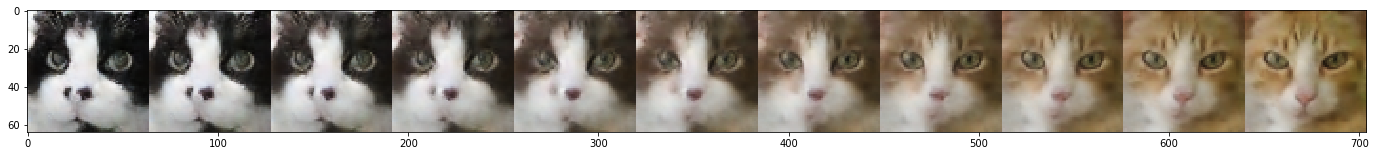

In [7]:
plt.figure(figsize=(24,16))
display.linear_interpolation(images[8], images[2099], encoder, decoder)

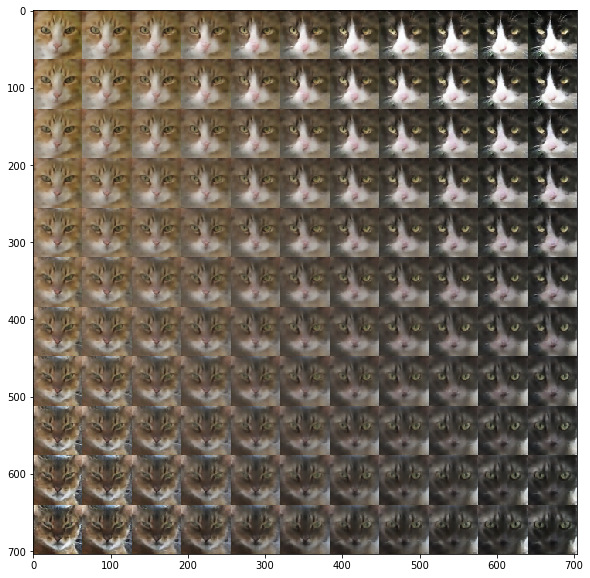

In [8]:
plt.figure(figsize=(10,10))
display.grid(images[2099], images[2020], images[6], images[2016], encoder, decoder)

In [9]:
anim_frames = []

num_faces = 10

for i in range(num_faces):
    frames = display.linear_interpolation_frames(images[i], images[i+1], encoder, decoder, steps=10)
    anim_frames.append(frames)
    
    
frames = display.linear_interpolation_frames(images[num_faces], images[0], encoder, decoder, steps=10)

anim_frames.append(frames)

In [10]:
anim_frames = np.array(anim_frames).reshape(11*(num_faces + 1), 64, 64, 3)

In [11]:
display.save_gif(anim_frames, 'faces.gif')